# Analyse af partiklen $K^0$s massefordeling med data fra ALEPH:
I denne notebook kommer du til at arbejde med data massefordelingen for $K^0$-partiklen, med data fra ALEPH-detektoren. Koden du møder vil i høj grad blive forklaret, men det mest essentielle er at du forsår fortolkningen af resultaterne.
___
## Teoriafsnint:
### $K^0$-partiklen:
Denne type partikel er en af de henfald der kan komme fra $V^0$ partiklen.
Vi skal i denne notebook undersøge massen af $K^0$ partikler med data fra ALEPH. Den er neutral og kaldes også for en kaon. Den er en del af "hadronfamilien" og tilhører mesonerne (kvark + antikvark). Kaonen består af en down-kvark og en anti-strange-kvark. 

$K^0 = (d) + (\bar{s})$

___ 
___
### I analysen bliver i bedt om:
Ved at bruge den tilgængelige data og jeres statistiske viden skal I:
1. Analysere fordelingen af massen af $K^0$-partikler:
    - Først for data
    - Så for Monte Carlo
2. Identificere peaket i fordelingen.
3. Bestemme massen af $K^0$-partiklen med præcision.
4. Sammenligne data med Monte Carlo data
5. Sammenligne værdien med Particle Data Groups' (PDG) tabelværdi

In [2]:
# Indlæs pakker 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.stats import chi2
from matplotlib.ticker import FuncFormatter
from scipy.optimize import curve_fit

## Åbne filer: 
Du skal åbne massefordelingerne for k0 data og k0 monte carlo data. 

In [3]:
# Åbne filerne 
k0 = np.load('k0_masse.npy')
k0_mc = np.load('k0_masse_mc.npy')

## Plot data 
1) Start med at køre cellen under igennem og se plottet for $K^0$ data. 
    - Besvar spørgsmål 1 under plot
2) Udkommenter derefter linjen der plotter monte carlo dataen for at se om de ligner hinanden
    - Besvar spørgsmål 2 under plot

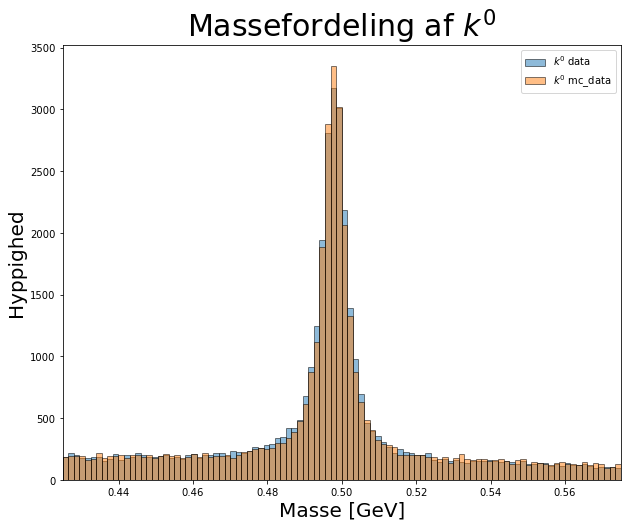

In [6]:
#Plot inputs (skal ikke ændres)
bins = 100
xmin, xmax = 0.425, 0.575
bin_range = (xmin, xmax) 

#Begynd plot
plt.figure(figsize=(10,8))
plt.title(f'Massefordeling af 'r'$k^0$', fontsize = 30) 


# Data for k0 partikkel
hist = plt.hist(k0, bins = bins, range = bin_range, label =  r'$k^0$' f' data', alpha = 0.5, edgecolor ='black')

# MC data for k0 partikkel:  
# Udkommentér linjen under for at se montecarlo dataen
plt.hist(k0_mc, bins = bins, range = bin_range,label = r'$k^0$' f' mc_data', alpha =0.5, edgecolor ='black')
###################################################

plt.xlim(xmin,xmax)
plt.xlabel('Masse [GeV]', fontsize = 20)
plt.ylabel('Hyppighed', fontsize = 20)
plt.legend()
plt.show()

### Hvad ser vi
1) Hvordan fordeler dataen sig?
2) Hvordan fordeler Monte Carlo dataen sig?

Svar <b>her:</b>
1) Den ligner meget en normalfordeling (Bemærk her er der intet "rigtigt" svar, men man skal bare skrive hvad man observerer)
2) Monte Carlo fordeler sig meget ligesom dataen med er en lille smule mindre i spredningen (det betyder skarpere signal)

___
<b><u>*Dette punkt er ikke vigtigt at forstå for analysen, men hvis du vil vide hvad der sker i koden er der nedunder givet en kort forklaring:<b><u>

## Fit funktioner og inputs: bare tryk [shift] + [enter] for at køre koden
    
### Beskrivelse af funktionerne
1. <b>Behandledata:</b> Laver histogram og gemmer inputs som vi skal bruge senere
2. <b>add_fit_info:</b> Indsætter tekst på plot
3. <b>fitfunktion (VIGTIG):</b> Det her er den funktion vi fitter efter. Altså vores bedste bud på at beskrive hvordan fordelingen opfører sig. Som du nok har bemærket, normalfordeler vores data og MC sig descærre ikke helt symmetrisk og derfor bliver man nødt til at tilføje noget mere til sit gæt. "gættefunktionen" er noget mere kompliceret end det du har lært om indtil videre, men kort fortalt er det 2 Gauss funktioner og 1 lineær funktion adderet sammen. 

### Forklaring af listen med startgæt
Under funktionerne ser du en liste med startgæt, dette er parameterværdier vi gætter som skal indsættes i funktionen.
- Værdien 0.0497 er et gæt på my (middelværdien), som vi har foretaget ud fra at aflæse hvor middelværdien i histogrammet foroven var placeret. (denne værdi er ens for begge gauss funktionerne)
- Værdierne 
    - 0.005 er gæt på spredningen for den første gauss 
    - 0.01 er gæt på spredningen for den anden gauss 
- Værdierne:
    - -100 er gæt for amplituden af den lineære funktion
    - 10 er gæt for hældningen af den lineære funktion 
    
### Fit for data og MC
I de 2 nederste afsnit af cellen nedenunder ser du hvordan vi laver fits ud fra de funktioner og startgæt vi har lavet. Sw outputs vi får, ved at gøre det på den her måde er både dataen,, fits, usikkerheder, parametrer og fejl (errors). 

In [7]:
# Funktioner der skal bruges
def behandledata(masse_data, bin_range, bins, startgæt, label):
    counts, bin_edges, _ = plt.hist(masse_data, bins = bins, range = bin_range, alpha = 0.5, edgecolor = 'black', label = label)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    uncertainties = np.sqrt(counts)
    plt.errorbar(bin_centers, counts, yerr=uncertainties, fmt='.')
    params, covariance = curve_fit(fitfunktion, bin_centers, counts, p0=startgæt, sigma=uncertainties, absolute_sigma=True)
    errors = np.sqrt(np.diag(covariance))
    return bin_centers, counts, uncertainties, params, errors

#Text på plot
def add_fit_info(params, label, color, x, y):
    mu = params[2]
    sigma1 = abs(params[1])
    plt.text(x, y, f"{label}:\n$\mu$ = {mu:.5f}\n$\sigma_1$ = {sigma1:.5f}", color=color, fontsize=14)
    
# Dobbelt gauss + lineær funktion
def fitfunktion(x, A1, mu, sigma1, A2, sigma2, k, m):
    gauss1 = A1*np.exp(-0.5 * ((x - mu) / sigma1) ** 2)
    gauss2 = A2 * np.exp(-0.5 * ((x - mu) / sigma2) ** 2)
    baggrund = k*x + m   
    return gauss1 + gauss2 + baggrund

# Startgæt
startgæt = [3500, 0.497, 0.005, 500, 0.01, -100, 10]

# Databehandling
fig = plt.figure()
# FIT FOR DATA
X, Y, yerr, params, errors = behandledata(k0, bin_range, bins, startgæt, label="Data")
x_fit = np.linspace(min(X), max(X), 1000)
y_fit = fitfunktion(x_fit, *params)
data_fit = plt.plot(x_fit, y_fit, label="Data k0 Fit", color='red')

# FIT FOR MC DATA
# Behandle MC-data
X_mc, Y_mc, yerr_mc, params_mc, errors_mc = behandledata(k0_mc, bin_range, bins, startgæt, label="MC Data")
x_fit_mc = np.linspace(min(X_mc), max(X_mc), 1000)
y_fit_mc = fitfunktion(x_fit_mc, *params_mc)
mc_fit = plt.plot(x_fit_mc, y_fit_mc, label="MC Fit", color='blue')

plt.close(fig) #Ikke lav et plot her (:

___
## Plot resultaterne(Lang plotfunktion): tryk [shift] + [enter]
Følgende afsnit visualiserer den databehandling i cellen foroven. Vi plotter flere plots i samme figur, derfor er det en meget lang kode. 

Når du har kørt cellen vil du se 3 plots: 
- Data + fit for massefordelingen af kaonen
- Monte Carlo data + MC fit for massefordelingen af kaonen
- Sammenligning af fits

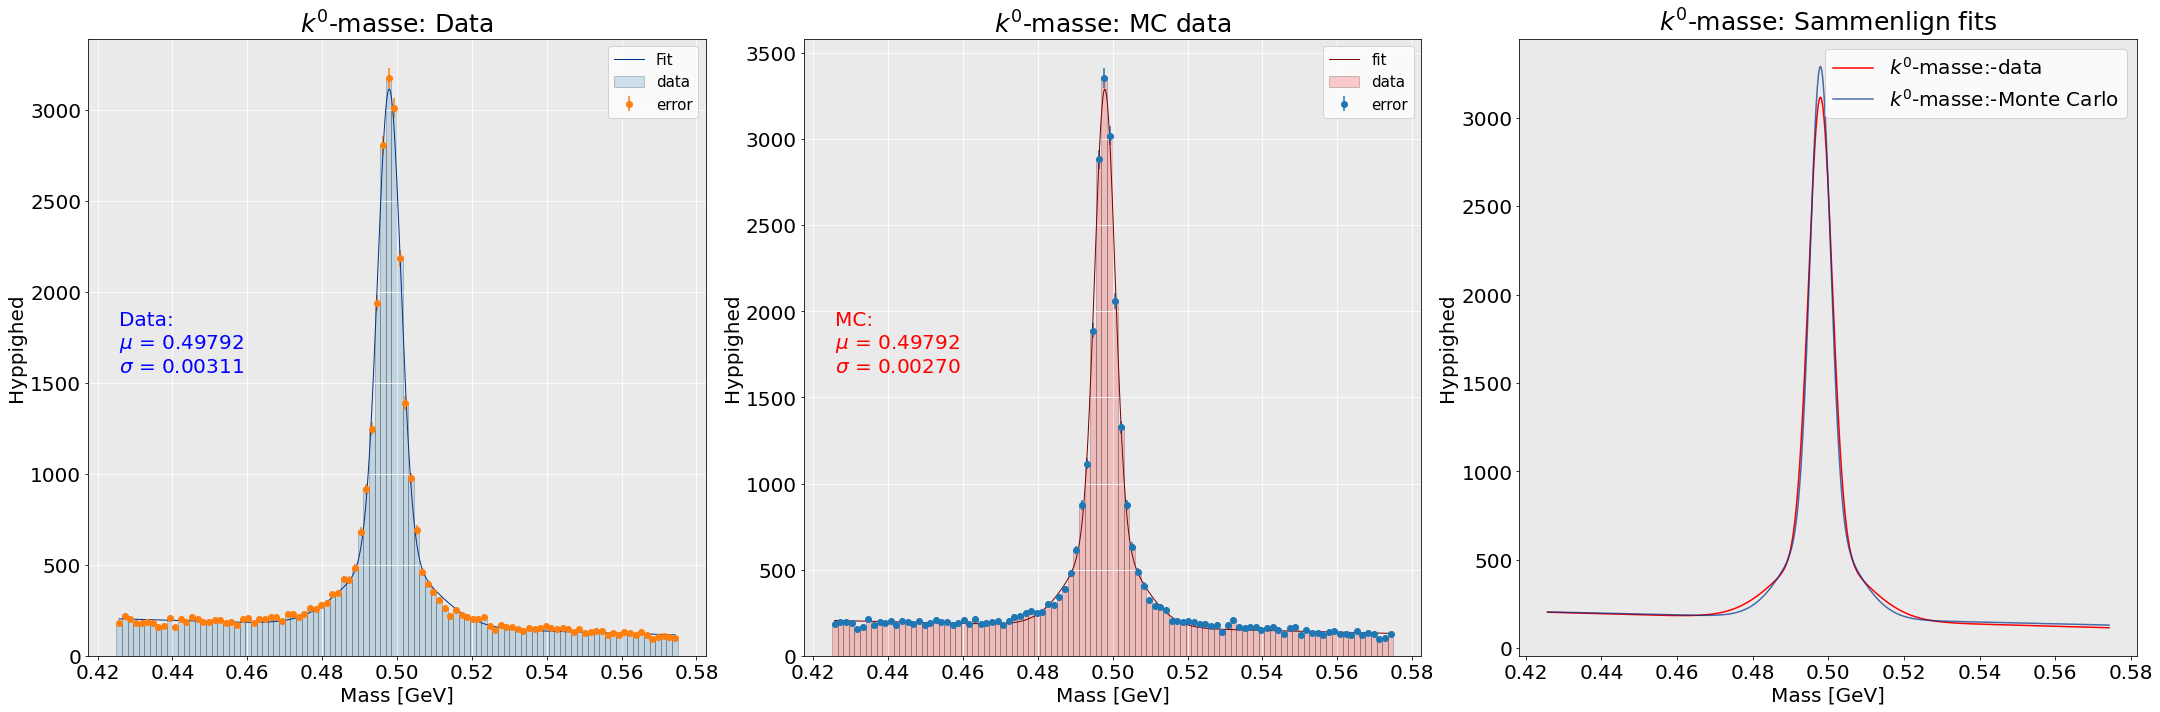

In [10]:
# Opret figur og gridspe
fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 3)

# Opret akser
axs = []
axs.append(fig.add_subplot(gs[0, 0]))  # Stor subplot
axs.append(fig.add_subplot(gs[0, 1]))   # Lille subplot øverst til højre
axs.append(fig.add_subplot(gs[0, 2]))   # Lille subplot nederst til højre

# Plot i stor s]ubplot
#text
axs[0].text(min(x_fit), max(y_fit) * 0.5, f"Data:\n$\mu$ = {params[1]:.5f}\n$\sigma$ = {abs(params[2]):.5f}", color='Blue', fontsize = 20)
axs[1].text(min(x_fit), max(y_fit_mc) * 0.5, f"MC:\n$\mu$ = {params_mc[1]:.5f}\n$\sigma$ = {abs(params_mc[2]):.5f}", color='Red', fontsize = 20)

# Data
axs[0].hist(k0, bins=bins, range=bin_range, alpha=0.2, edgecolor='black', label='data')
axs[0].plot(x_fit, y_fit,label='Fit', linewidth = 1 ,color = '#00338c')
axs[0].errorbar(X, Y, yerr=yerr, fmt='o', label = 'error')
axs[0].set_title(r'$k^0$'f'-masse: Data', fontsize =25)
axs[0].set_xlabel("Mass [GeV]", fontsize = 20)
axs[0].set_ylabel("Hyppighed", fontsize = 20)
axs[0].legend(fontsize=15)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_facecolor('#eaeaea')
axs[0].grid(color = 'w')

# MC
axs[1].hist(k0_mc, bins=bins, range=bin_range, alpha=0.2, color='red', edgecolor='black', label='data')
axs[1].plot(x_fit_mc, y_fit_mc ,linewidth = 1, label="fit", color="#780000")
axs[1].errorbar(X_mc, Y_mc, yerr=yerr_mc, fmt='o', label = 'error')
axs[1].set_title(r'$k^0$'f'-masse: MC data', fontsize = 25)
axs[1].set_xlabel("Mass [GeV]", fontsize = 20)
axs[1].set_ylabel("Hyppighed", fontsize = 20)
axs[1].legend(fontsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_facecolor('#eaeaea')
axs[1].grid(color = 'w')

#FITS
axs[2].plot(x_fit, y_fit, label=r'$k^0$'f'-masse:-data', color="#ff0000", alpha=1)
axs[2].plot(x_fit_mc, y_fit_mc, label=r'$k^0$'f'-masse:-Monte Carlo', color="#00338c", alpha = 0.7)
axs[2].set_title(r'$k^0$'f'-masse: Sammenlign fits', fontsize = 25)
axs[2].set_xlabel("Mass [GeV]", fontsize = 20)
axs[2].set_ylabel("Hyppighed", fontsize = 20)
axs[2].legend(fontsize=20)
axs[2].tick_params(axis='both', which='major', labelsize=20)
axs[2].set_facecolor('#eaeaea')

# Tilføj en stor overtitel
#    fig.suptitle(f' {title}-Massplots', fontsize= 40, va = 'bottom')
# Juster layout
fig.tight_layout()
#plt.savefig(saveas)
plt.show()

### Hvordan tolker vi resultaterne?
For at sige noget om massefordelingen for $K^0$ partiklerne skal vi bruge det vi lærte i statistik-delen. 
tip: 
- $\mu = $ my) middelværdien
- $\sigma = $ sigma) spredningen

Svar på følgende:
1) Hvad kan vi sige om middelværdien?
2) Hvad kan vi sige om spredningen?
3) Opfører vores data sig som den tilfældigt genererede Monte Carlo data? 

<b> Indsæt svar her:</b>
1) middelværdien for 
    - data: 0.49792 
    - MC: 0.49792
Den er det samme for begge fordelinger!
2) Spredningen for:
    - data: 0.00311
    - MC: 0.00270    
Den er bredere for data. 
3) Ja dataen opfører os som den generede monte carlo data. Der er ikke særlig stor forskel på spredningen.

## $\chi^2$-test: passer vores model med den teoretiske? 
I statistik-delen lærte vi at man opstiller en nulhypotese og bestemmer signifikantsniveau inden man foretager $\chi^2$ testen:

<b>Nulhypotese:</b> Der er en sammenhæng mellem vores fit-funktion, (dobbeltgauss + lineær) og den udleverede data for massefordelingen af $K^0$ partiklerne der er målt i ALEPH eksperimentet.

<b>Signifikans:</b> 0.05 (5%)

- Inden du kører cellen bedes du om at kigge endnu engang på data og fit og give et gæt på om vores $chi^2$-test overholder signifikans. 

Cellen nedenunder skal bare køres: [shift]+[enter]

du vil derefter se værdierne for $\chi^2$-testen for både data og Monte Carlo:

In [11]:
#CHI2 funktion
def calculate_chi2(X, Y, yerr, params, fitfunc_K0):
    y_model = fitfunc_K0(X, *params)
    chi2_val = np.sum(((Y - y_model) / yerr) ** 2)
    dof = len(X) - len(params)
    p_value = chi2.sf(chi2_val, dof)
    return chi2_val, dof, p_value

# Beregn og udskriv chi2 for data
chi2_data, dof_data, p_value_data = calculate_chi2(X, Y, yerr, params, fitfunktion)
print(f"Data: Chi2 = {chi2_data:.2f}, Frihedsgrader = {dof_data}, p-værdi = {p_value_data:.3f}")
chi2_mc, dof_mc, p_value_mc = calculate_chi2(X_mc, Y_mc, yerr_mc, params_mc, fitfunktion)
print(f"MC: Chi2 = {chi2_mc:.2f}, Frihedsgrader = {dof_mc}, p-værdi = {p_value_mc:.3f}")


Data: Chi2 = 214.96, Frihedsgrader = 93, p-værdi = 0.000
MC: Chi2 = 220.43, Frihedsgrader = 93, p-værdi = 0.000


### Spørgsmål:
1) Hvad betyder p-værdien i det her tilfælde?
2) Er det et dårligt fit?

Svar <b>her:</b>
1) P værdien er 0, altså lavere end den signifikans som vi satte til at starte med. Dette betyder at vi må forkaste nulhypotesen. 
2) Det kommer an på hvad man vil bruge det til. Senere (når vi sammenligner med tabelværdi) vil vi se at fittet fungerede til at bestemme middelværdien, men elendig til at bestemme spredningen.

### Hvordan tolker vi resultatet?
Vores $\chi^2$ værdi er høj, p-værdien er 0. Betyder det at vi har en ringe model? 

Svaret ligger i 2 argumenter:
<b>big data:</b> Selvom det ligner at vores fit læner sig tæt op af dataen, er det vigtigt at huske på at det er 55 000 events der fittes efter. Når man arbejder med så meget data, skal fittet ligge enormt tæt op af fordelingen. Denne del af databehandling er en delikat process, som med meget små ændringer i sine startgæt kan have afgørende betydning for de fits man laver. Og det er jo dem der skal beskrive hvad vi observerer i naturen. 

<b> Frihedsgrader:</b> Fordi at vores antal frihedsgrader er så langt fra $\chi^2$-værdien. Dette skyldes:

- høj statistik
- små usikkerheder 
___
## Sammenlign med tabelværdien
De teoretiske værdier man sammenligner sine resultater med i partikelfysik findes på "Particle Data Group(PDG)", som er et internationalt samarbejde der leverer omfattende opsummeringer af partikel fysik og relaterede områder af kosmologi: "The Review of Particle Physics".

- PDG teoretisk værdi for $K^0$-masse findes [her](https://pdg.lbl.gov/2018/listings/rpp2018-list-K-zero.pdf)

Stemmer dine værdier overens med tabelværdien?

497.611±0.013 OUR FIT Error includes scale factor of 1.2.
497.611±0.013 OUR AVERAGE 013 OUR AVERAGE 013 OUR AVERAGE

Er er det vigtigt at bemærke tabelværdien er vist i Mega elektrovolt og vores data er vist i Giga elektrovolt. Derfor sammenligner vi altså med:
   - data: $497.92 \pm 3.11$
   - MC: $497.92 \pm 2.7$
Her kan vi altså tydeligt se at vores spredninger er enorm store sammenlignet mmed de tal Particle Data Group leverer. Jeg håber det kan give en bedre idé om hvor stor en nøjagtighed man forsøger at måle med og hvorfor vores $\chi^2$-test ikke leve

___

## Konklusion
Du har nu gennemgået følgende emner:
#### 1) Hente ekstern data fra ALEPH ned til din notebook
I statistik-delen prøvede du selv at generere data som du arbejdede med, men i denne notebook skulle vi gente ekstern data som var foretaget af nogen andre. 

#### 2) Visualisering af massefordeling
Vi prøvede allerede at visualiserede data i statistik-delen. Nu fik vi plottet vores massefordeling af data og Monte Carlo data i et histogram for $K^0$-partiklerne. Ved at gøre dette, havde vi mulighed for at afgive kvalificerede gæt på vores fitfunktions inputparametre. 

#### 3) Fitfunktion: 
Databehandling og fitfunktionen. Denne del var mere udybdegående end hvad vi tidligere har gennemgået. Vi har 
- Defineret en funktion der tog sig af at trække den relevante data ud fra histogrammerne. 
- Defineret en fitfunktion som er et bud på hvordan vores data opfører sig.
- indtastet de kvalificerede startgæt for parametrene i vores fitfunktion.

#### 4) Plot dit fit sammen med histogram data
Ved at plotte vores fit for data og Monte Carlo data fik vi visualiseret hvor tæt vores fit lagde sig omkring den data vi arbejder med. 
Vi sammenlignede også vores fit for data og Monte Carlo for at se om de ligner hinanden.
#### 5) Udført en $\chi^2$-test på dit fit
I statistik-delen blev vi introduceret for $\chi^2$-test. Vi har foretaget den på vores $K^0$-masse fits og set om den stemmer overens med fordelingen. Selvom det visuelt ligner at fittet er tæt op af data, afslører $\chi^2$-testen, at når man arbejder med så store datasæt, har selv små afvigelser stor betydning for hvor gode ens resultater er. 
#### 6) Sammenlignet dine resultater med den teoretiske tabel-værdi fra PDG. 
Vi har på baggrund af vores dataanalyse sammenlignet vores resultater med en teoretisk tabelværdi. 
___
___

Tillykke, du er nu færdig med den sidste del af projektet!